In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path =  '/content/drive/MyDrive/Colab Notebooks/ECE 219/'

In [3]:
!pip install lightgbm
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.tree import plot_tree

from skopt import BayesSearchCV
import lightgbm as lgb

In [5]:
diamonds_data = pd.read_csv( path + "diamonds.csv")
diamonds_data = diamonds_data.drop(diamonds_data.columns[[0]], axis = 1)
diamonds_data_original = diamonds_data.copy()
diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,327,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,328,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,337,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,338,4.34,4.35,2.75


In [6]:

map_cut = {}
map_cut['Ideal'] = 4
map_cut['Premium'] = 3
map_cut['Very Good'] = 2
map_cut['Good'] = 1
map_cut['Fair'] = 0
diamonds_data['cut'] = diamonds_data['cut'].map(map_cut)

map_color = {}
map_color['D'] = 6 
map_color['E'] = 5
map_color['F'] = 4
map_color['G'] = 3
map_color['H'] = 2
map_color['I'] = 1
map_color['J'] = 0
diamonds_data['color'] = diamonds_data['color'].map(map_color)

map_clarity = {}
map_clarity['IF'] = 7 
map_clarity['VVS1'] = 6 
map_clarity['VVS2'] = 5
map_clarity['VS1'] = 4
map_clarity['VS2'] = 3
map_clarity['SI1'] = 2
map_clarity['SI2'] = 1
map_clarity['I1'] = 0
diamonds_data['clarity'] = diamonds_data['clarity'].map(map_clarity)

diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,330,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,327,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,328,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,337,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,338,4.34,4.35,2.75


Standardization (Code copied from other team ipynb)

In [15]:
def standardize_data(X_train, X_test, y_train, y_test):

    # Standardize the feature columns
    scaler = StandardScaler()
    cols = list(set(X_train.columns).intersection(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']))
    X_train[cols] = scaler.fit_transform(X_train[cols])
    X_test[cols] = scaler.transform(X_test[cols])

    return X_train, X_test, y_train, y_test

def standardize_data_train(X_train, y_train ):

    # Standardize the feature columns
    scaler = StandardScaler()
    cols = list(set(X_train.columns).intersection(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']))
    X_train[cols] = scaler.fit_transform(X_train[cols])

    return X_train, y_train

In [8]:
# Only to show how standardization is done
X = diamonds_data.drop(columns='price')
y = diamonds_data['price']
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = standardize_data(X_train, X_test, y_train, y_test)
X_train_std.head()

,carat,cut,color,clarity,depth,table,x,y,z
26546,2.560056,-1.708965,0.347949,-1.246901,-2.550748,2.933861,2.229450,2.138209,1.738207
9159,0.447392,-0.812192,0.936621,-1.246901,-1.220426,1.139575,0.747550,0.656710,0.537733
14131,0.637532,0.084582,-0.829396,-0.032134,0.529996,0.242432,0.765404,0.700284,0.791951
15757,1.482597,-1.708965,0.936621,-1.246901,-0.170173,3.382432,1.318885,1.249310,1.243894
24632,1.524851,-0.812192,-0.240724,0.575249,0.249928,-0.206140,1.372448,1.380030,1.399249


In [9]:
#from earlier results

# Define the number of features to select
k_val = 6

# Select the top k features using F-regression and mutual information regression
selector_FR = SelectKBest(score_func=f_regression, k=k_val)
selector_MIR = SelectKBest(score_func=mutual_info_regression, k=k_val)
     

For each section, train and compare their performance using average RSME from 10-fold cross validation

For random forest model, measure OOB Error as well. (Q3)

# Section 3.3.4

In [12]:
# Standardize the data for all folds separately
scaler_train = StandardScaler()
scaler_test = StandardScaler()

# Define the models to train with pipeline
models = [Pipeline([
               ('scaler', StandardScaler()),
               ('random_forest_FR', RandomForestRegressor())
           ]), 
          Pipeline([
               ('scaler', StandardScaler()),
               ('random_forest_MIR', RandomForestRegressor())
           ]),
          Pipeline([
               ('scaler', StandardScaler()),
               ('random_forest_all_features', RandomForestRegressor())
           ])]

# Define the hyperparameters for grid search
params = [
          {     'random_forest_FR__n_estimators': [ 10, 50, 75 ],
                'random_forest_FR__max_depth': [ 2, 4 ],
                'random_forest_FR__max_features': [ 2, 4, 6 ],
                'random_forest_FR__n_jobs': [ -1 ]
          },
          {
              'random_forest_MIR__n_estimators': [ 10, 50, 75 ],
              'random_forest_MIR__max_features': [ 2, 4, 6 ],
              'random_forest_MIR__max_depth': [ 2, 4 ],
              'random_forest_MIR__n_jobs': [ -1 ]
           },
          {
              'random_forest_all_features__n_estimators': [ 10, 50, 75 ],
              'random_forest_all_features__max_features': [ 1, 2, 4, 8, 9 ],
              'random_forest_all_features__max_depth': [ 2, 4 ],
              'random_forest_all_features__n_jobs': [ -1 ]
           }]


# Train each model with grid search and evaluate its performance
for i, model in enumerate(models):
    # Perform grid search with 10-fold cross-validation and measure average RMSE errors for training and validation sets
    if i == 0:
        selector_FR = SelectKBest(score_func=f_regression, k=k_val)
        X_selected = selector_FR.fit_transform(X, y)
        grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=KFold(10), n_jobs=-1, return_train_score=True)
        grid.fit(X_selected, y)
        print('{} with standardization and F-regression feature selection:'.format(type(model.steps[-1][-1]).__name__))
    elif i == 1:
        selector_MIR = SelectKBest(score_func=mutual_info_regression, k=k_val)
        X_selected = selector_MIR.fit_transform(X, y)
        grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=KFold(10), n_jobs=-1, return_train_score=True)
        grid.fit(X_selected, y)
        print('{} with standardization and mutual information regression feature selection:'.format(type(model.steps[-1][-1]).__name__))
    elif i == 2:
        grid = GridSearchCV(model, params[i], scoring='neg_root_mean_squared_error', cv=KFold(10), n_jobs=-1, return_train_score=True)
        grid.fit(X, y)
        print('{} with standardization and mutual information regression feature selection:'.format(type(model.steps[-1][-1]).__name__))

    # Print the best hyperparameters and the corresponding scores for training and validation sets
    print('Best hyperparameters:', grid.best_params_)
    print('Training set RMSE:', grid.cv_results_['mean_train_score'][grid.best_index_])
    print('Validation set RMSE:', grid.cv_results_['mean_test_score'][grid.best_index_])
    print()

RandomForestRegressor with standardization and F-regression feature selection:
Best hyperparameters: {'random_forest_FR__max_depth': 4, 'random_forest_FR__max_features': 4, 'random_forest_FR__n_estimators': 50, 'random_forest_FR__n_jobs': -1}
Training set RMSE: -1038.153878867562
Validation set RMSE: -1277.9753521934022

RandomForestRegressor with standardization and mutual information regression feature selection:
Best hyperparameters: {'random_forest_MIR__max_depth': 4, 'random_forest_MIR__max_features': 4, 'random_forest_MIR__n_estimators': 75, 'random_forest_MIR__n_jobs': -1}
Training set RMSE: -1036.2254187392439
Validation set RMSE: -1274.73664480602

RandomForestRegressor with standardization and mutual information regression feature selection:
Best hyperparameters: {'random_forest_all_features__max_depth': 4, 'random_forest_all_features__max_features': 4, 'random_forest_all_features__n_estimators': 75, 'random_forest_all_features__n_jobs': -1}
Training set RMSE: -1079.687462535

In [33]:
#make model based on result

# Standardize the data for all folds separately
scaler_train = StandardScaler()
scaler_test = StandardScaler()

# Define the models to train with pipeline
model = RandomForestRegressor( n_estimators=75, max_depth=4, max_features=4, n_jobs=-1, oob_score=True)

selector_FR = SelectKBest(score_func=f_regression, k=k_val)
X_selected = selector_FR.fit_transform(X, y)
cols = X.columns[selector_FR.get_support()]
X_train_std = scaler_train.fit_transform(X_selected)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_std, y)

model.fit( X_train_std, y)
estimator = model.estimators_[0]



oob_error = 1 - model.oob_score_
print(oob_error)

0.07066837001951021


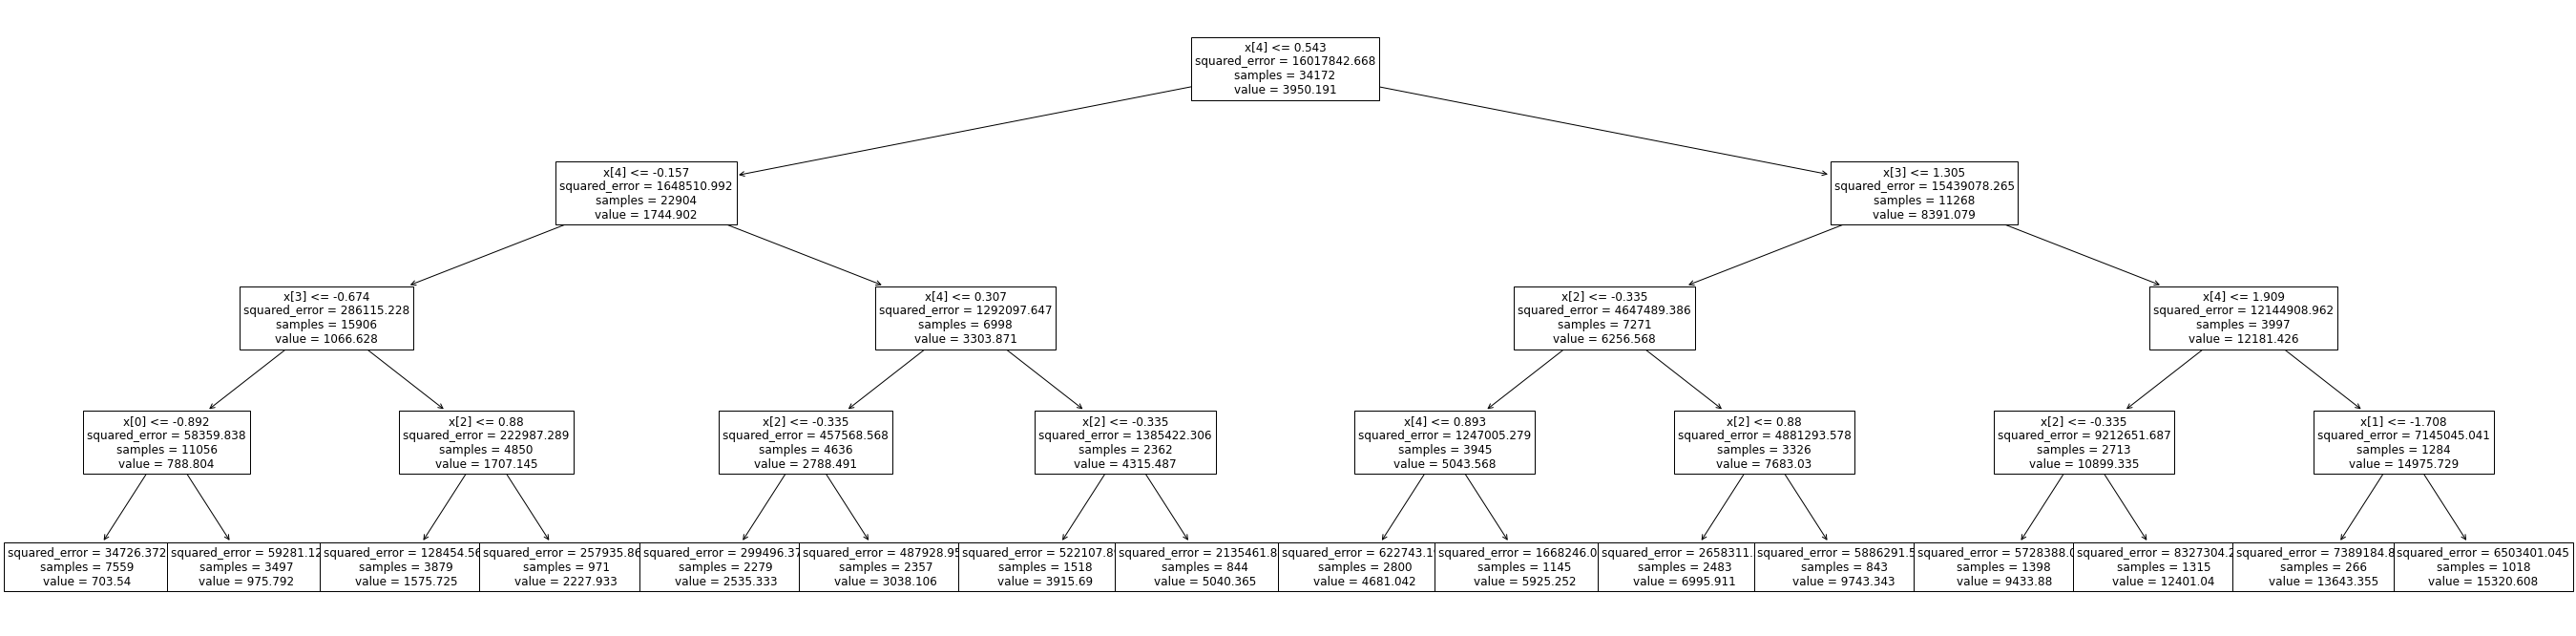

In [37]:
plt.figure(figsize=(48,12))
plot_tree(estimator, fontsize=12)
plt.show()

# Section 3.3.5

In [16]:
train_data = lgb.Dataset(X_train, label=y_train)

#using https://www.kaggle.com/code/lucamassaron/scikit-optimize-for-lightgbm as a reference for how to use LightGBM with BayesSearch

def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + "candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:', best_params)
    return best_params

clf = lgb.LGBMRegressor( verbose=-1, random_state=0 )

params = {
    'learning_rate': [0.01, 0.1, 0.5],     # Boosting learning rate
    'n_estimators': [50, 100, 200],                   # Number of boosted trees to fit
    'num_leaves': [ 50, 100, 200],                       # Maximum tree leaves for base learners
    'max_depth': [ 1, 4, 10 ],                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': [ 1, 3, 9 ],                # Minimal number of data in one leaf
    'reg_lambda': [ 0.0001, 0.001, 0.01, 0.1 ],      # L2 regularization
}

cv = KFold(10)

opt = BayesSearchCV(estimator=clf,                                    
                    search_spaces=params,                                                      
                    cv=cv,
                    scoring='neg_root_mean_squared_error'                                         
 )

X_train_std, y_train_std = standardize_data_train(X_train, y_train )

# log-uniform: understand as search over p = exp(x) by varying x
best_params = report_perf(opt, X_train_std, y_train_std,'LightGBM')

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packa

LightGBMcandidates checked: 50, best CV score: -540.271 ± 22.167
Best parameters: OrderedDict([('learning_rate', 0.1), ('max_depth', 4), ('min_child_samples', 3), ('n_estimators', 200), ('num_leaves', 200), ('reg_lambda', 0.01)])


In [30]:
print(best_params)

OrderedDict([('learning_rate', 0.1), ('max_depth', 4), ('min_child_samples', 3), ('n_estimators', 200), ('num_leaves', 200), ('reg_lambda', 0.01)])


In [20]:
d=pd.DataFrame(opt.cv_results_)
best_score = opt.best_score_
best_score_std = d.iloc[opt.best_index_].std_test_score

In [23]:
d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_samples,param_n_estimators,param_num_leaves,param_reg_lambda,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.564587,0.292386,0.020313,0.005490,0.1,1,9,100,50,0.1,...,-1201.945602,-1195.104626,-1190.078174,-1198.870338,-1148.878459,-1166.286342,-1171.710285,-1181.397865,28.191804,48
1,1.288939,1.096791,0.041766,0.022620,0.5,4,3,200,50,0.01,...,-553.381032,-588.099078,-565.459239,-586.473008,-553.495107,-574.808287,-582.251486,-567.606059,20.259951,42
2,0.427521,0.012963,0.030094,0.000941,0.1,4,3,200,200,0.01,...,-531.085042,-556.452114,-533.507927,-567.720695,-508.646109,-545.044789,-529.054170,-540.270815,22.167020,1
3,0.719917,0.964610,0.027074,0.001699,0.5,4,3,200,100,0.0001,...,-565.213424,-574.879407,-563.572661,-602.606512,-536.418157,-572.720165,-581.218366,-567.485641,19.845277,41
4,0.108503,0.004202,0.007487,0.003458,0.5,1,3,50,100,0.001,...,-1141.353877,-1137.899050,-1125.966851,-1132.362826,-1094.232340,-1108.085307,-1102.717009,-1120.067543,26.260189,46
5,0.110074,0.006960,0.005738,0.000240,0.01,1,9,50,50,0.001,...,-3009.420686,-3076.079317,-3008.795514,-3126.689207,-2975.094845,-2986.871213,-3102.585725,-3032.385914,67.293353,50
6,0.108890,0.006379,0.006239,0.000730,0.5,1,9,50,50,0.1,...,-1141.355973,-1137.900246,-1125.968153,-1132.363627,-1094.233009,-1108.087075,-1102.717593,-1120.068839,26.260453,47
7,0.272996,0.019385,0.017057,0.000993,0.1,4,1,100,50,0.01,...,-546.429070,-566.695864,-547.778591,-581.060547,-518.231499,-556.436718,-543.780134,-553.408772,25.312362,40
8,0.237448,0.182809,0.010618,0.003091,0.5,1,1,100,200,0.1,...,-1092.050376,-1099.124067,-1085.359816,-1091.068647,-1055.396489,-1062.830338,-1060.620119,-1078.265884,24.485116,45
9,0.474375,0.533646,0.013377,0.000414,0.01,4,3,100,100,0.01,...,-1717.842407,-1762.436808,-1712.876956,-1788.378509,-1675.429698,-1698.331747,-1767.756638,-1729.506932,46.120729,49
